<a href="https://colab.research.google.com/github/ananyapahwa/Body-fat-prediction/blob/main/body-fat-predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTING DATASET

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.stats import zscore
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

LOADING THE DATASET



In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ananyapahwa82","key":"73f37d4687b60985e000854d6009f24b"}'}

In [4]:
# Step 1: Remove the file if it exists
!rm -f ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
import kagglehub

path = kagglehub.dataset_download("valakhorasani/gym-members-exercise-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gym-members-exercise-dataset


In [6]:
import pandas as pd
df = pd.read_csv('/kaggle/input/gym-members-exercise-dataset/gym_members_exercise_tracking.csv')
df.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39


## **DATASET PRE-PROCESSING**

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

In [8]:
df.isna().sum()

,0
Age,0
Gender,0
Weight (kg),0
Height (m),0
Max_BPM,0
Avg_BPM,0
Resting_BPM,0
Session_Duration (hours),0
Calories_Burned,0
Workout_Type,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    float64
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

# OUTLIER DETECTIONS
(we will be using z-score for the outlier detection)

In [10]:
categorical_features = [
    'Workout_Type',
    'Gender'
]
z_scores = zscore(df.drop(columns=categorical_features,axis=1))
df_filtered = df[(abs(z_scores) < 3.5).all(axis=1)]
df_filtered

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
0,56,Male,88.3,1.71,180,157,60,1.69,1313.0,Yoga,12.6,3.5,4,3,30.20
1,46,Female,74.9,1.53,179,151,66,1.30,883.0,HIIT,33.9,2.1,4,2,32.00
2,32,Female,68.1,1.66,167,122,54,1.11,677.0,Cardio,33.4,2.3,4,2,24.71
3,25,Male,53.2,1.70,190,164,56,0.59,532.0,Strength,28.8,2.1,3,1,18.41
4,38,Male,46.1,1.79,188,158,68,0.64,556.0,Strength,29.2,2.8,3,1,14.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
968,24,Male,87.1,1.74,187,158,67,1.57,1364.0,Strength,10.0,3.5,4,3,28.77
969,25,Male,66.6,1.61,184,166,56,1.38,1260.0,Strength,25.0,3.0,2,1,25.69
970,59,Female,60.4,1.76,194,120,53,1.72,929.0,Cardio,18.8,2.7,5,3,19.50
971,32,Male,126.4,1.83,198,146,62,1.10,883.0,HIIT,28.2,2.1,3,2,37.74


splitting the data into testing and training

In [11]:
X = df_filtered.drop(columns=['Fat_Percentage'], axis=1)
y = df_filtered['Fat_Percentage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((776, 14), (195, 14), (776,), (195,))

# DATA TRANSFORMATION
Converting the categorical features to Numeric Data


*   For Gender, which is a binary feature, we can either use dummy encoding or label encoding, which will give us the same results.

    Male = 1

    Female = 0
*  For Workout_Type, we might use One Hot Encoding



In [12]:
X_train_transformed = X_train.copy(deep=True)
X_train_transformed['Gender'] = X_train_transformed['Gender'].map({'Female': 0, 'Male': 1})
X_train_transformed

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
865,21,1,101.2,1.84,181,132,50,1.30,944.0,Yoga,3.3,2,1,29.89
192,19,0,65.2,1.52,188,130,71,1.23,800.0,Cardio,2.4,3,1,28.22
309,23,0,59.0,1.78,185,141,58,1.67,1177.0,Yoga,2.7,5,3,18.62
477,51,0,66.2,1.58,164,129,65,0.86,499.0,HIIT,2.3,3,1,26.52
896,22,0,61.8,1.52,169,166,61,1.83,1519.0,Yoga,2.7,5,3,26.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,41,1,71.7,1.96,162,168,51,0.51,424.0,Yoga,2.5,2,1,18.66
270,19,0,58.8,1.77,181,136,53,1.40,952.0,HIIT,2.7,2,1,18.77
861,19,0,46.8,1.63,184,128,63,1.35,864.0,HIIT,1.6,4,2,17.61
435,51,0,56.3,1.50,182,142,66,1.43,914.0,Cardio,2.4,3,1,25.02


In [13]:
X_train_transformed['Workout_Type'].value_counts()


,count
Workout_Type,
Strength,210
Cardio,204
Yoga,189
HIIT,173


In [14]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
workout_encoded = encoder.fit_transform(X_train_transformed[['Workout_Type']])

workout_encoded_df = pd.DataFrame(
    workout_encoded,
    columns=encoder.get_feature_names_out(['Workout_Type']),
    index=X_train_transformed.index
)

X_train_transformed2 = pd.concat([X_train_transformed.drop('Workout_Type', axis=1), workout_encoded_df], axis=1)
X_train_transformed2

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Workout_Type_Cardio,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga
865,21,1,101.2,1.84,181,132,50,1.30,944.0,3.3,2,1,29.89,0.0,0.0,0.0,1.0
192,19,0,65.2,1.52,188,130,71,1.23,800.0,2.4,3,1,28.22,1.0,0.0,0.0,0.0
309,23,0,59.0,1.78,185,141,58,1.67,1177.0,2.7,5,3,18.62,0.0,0.0,0.0,1.0
477,51,0,66.2,1.58,164,129,65,0.86,499.0,2.3,3,1,26.52,0.0,1.0,0.0,0.0
896,22,0,61.8,1.52,169,166,61,1.83,1519.0,2.7,5,3,26.75,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,41,1,71.7,1.96,162,168,51,0.51,424.0,2.5,2,1,18.66,0.0,0.0,0.0,1.0
270,19,0,58.8,1.77,181,136,53,1.40,952.0,2.7,2,1,18.77,0.0,1.0,0.0,0.0
861,19,0,46.8,1.63,184,128,63,1.35,864.0,1.6,4,2,17.61,0.0,1.0,0.0,0.0
435,51,0,56.3,1.50,182,142,66,1.43,914.0,2.4,3,1,25.02,1.0,0.0,0.0,0.0


In [15]:
# Transforming the test data
X_test_transformed = X_test.copy(deep=True)
X_test_transformed['Gender'] = X_test_transformed['Gender'].map({'Female': 0, 'Male': 1})
test_encodings = encoder.transform(X_test_transformed[['Workout_Type']])
test_encodings_df = pd.DataFrame(
    test_encodings,
    columns=encoder.get_feature_names_out(['Workout_Type']),
    index=X_test_transformed.index
)
X_test_transformed2 = pd.concat([X_test_transformed.drop('Workout_Type', axis=1), test_encodings_df], axis=1)
X_test_transformed2

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Workout_Type_Cardio,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga
168,54,0,72.3,1.78,163,149,72,1.27,852.0,1.8,2,1,22.82,1.0,0.0,0.0,0.0
836,23,0,65.2,1.62,192,156,59,1.37,1069.0,2.5,3,2,24.84,1.0,0.0,0.0,0.0
76,42,0,53.7,1.72,183,142,74,1.37,875.0,1.6,3,1,18.15,1.0,0.0,0.0,0.0
70,57,0,64.0,1.52,170,129,52,1.73,1004.0,2.7,5,3,27.70,0.0,0.0,1.0,0.0
88,28,1,81.6,1.66,174,153,50,1.09,917.0,3.5,4,2,29.61,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,20,1,55.0,1.60,172,168,67,1.12,1035.0,3.2,4,2,21.48,0.0,0.0,0.0,1.0
633,53,1,68.5,1.97,194,139,69,1.30,894.0,2.1,3,2,17.65,0.0,1.0,0.0,0.0
557,22,1,86.2,1.90,186,128,58,1.91,1345.0,3.5,5,3,23.88,0.0,0.0,1.0,0.0
33,24,0,58.9,1.51,187,157,68,1.04,816.0,2.5,2,1,25.83,1.0,0.0,0.0,0.0


In [16]:
os.makedirs("model", exist_ok=True)
joblib.dump(encoder, 'model/workout_type_encoder.pkl')

['model/workout_type_encoder.pkl']

# Scaling and Normalization

for scaling using minmax Scaler from sckit learn package

In [17]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_transformed2)
X_train_transformed_scaled = pd.DataFrame(
    X_train_scaled,
    columns=X_train_transformed2.columns,
    index=X_train_transformed2.index
)

X_train_transformed_scaled.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Workout_Type_Cardio,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga
865,0.073171,1.0,0.680756,0.68,0.538462,0.244898,0.000000,0.533333,0.426913,0.818182,0.000000,0.0,0.506924,0.0,0.0,0.0,1.0
192,0.024390,0.0,0.280311,0.04,0.717949,0.204082,0.875000,0.486667,0.328552,0.409091,0.333333,0.0,0.458742,1.0,0.0,0.0,0.0
309,0.121951,0.0,0.211346,0.56,0.641026,0.428571,0.333333,0.780000,0.586066,0.545455,1.000000,1.0,0.181766,0.0,0.0,0.0,1.0
477,0.804878,0.0,0.291435,0.16,0.102564,0.183673,0.625000,0.240000,0.122951,0.363636,0.333333,0.0,0.409694,0.0,1.0,0.0,0.0
896,0.097561,0.0,0.242492,0.04,0.230769,0.938776,0.458333,0.886667,0.819672,0.545455,1.000000,1.0,0.416330,0.0,0.0,0.0,1.0


In [18]:
X_test_scaled = scaler.transform(X_test_transformed2)
X_test_transformed_scaled = pd.DataFrame(
    X_test_scaled,
    columns=X_test_transformed2.columns,
    index=X_test_transformed2.index
)
X_test_transformed_scaled.head()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Workout_Type_Cardio,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga
168,0.878049,0.0,0.359288,0.56,0.076923,0.591837,0.916667,0.513333,0.364071,0.136364,0.000000,0.0,0.302943,1.0,0.0,0.0,0.0
836,0.121951,0.0,0.280311,0.24,0.820513,0.734694,0.375000,0.580000,0.512295,0.454545,0.333333,0.5,0.361223,1.0,0.0,0.0,0.0
76,0.585366,0.0,0.152392,0.44,0.589744,0.448980,1.000000,0.580000,0.379781,0.045455,0.333333,0.0,0.168205,1.0,0.0,0.0,0.0
70,0.951220,0.0,0.266963,0.04,0.256410,0.183673,0.083333,0.820000,0.467896,0.545455,1.000000,1.0,0.443739,0.0,0.0,1.0,0.0
88,0.243902,1.0,0.462736,0.32,0.358974,0.673469,0.000000,0.393333,0.408470,0.909091,0.666667,0.5,0.498846,0.0,0.0,0.0,1.0


In [19]:
joblib.dump(scaler, 'model/minmax_scaler.pkl')

['model/minmax_scaler.pkl']

#Feature Selection

Checking the correlation between different features

<Axes: >

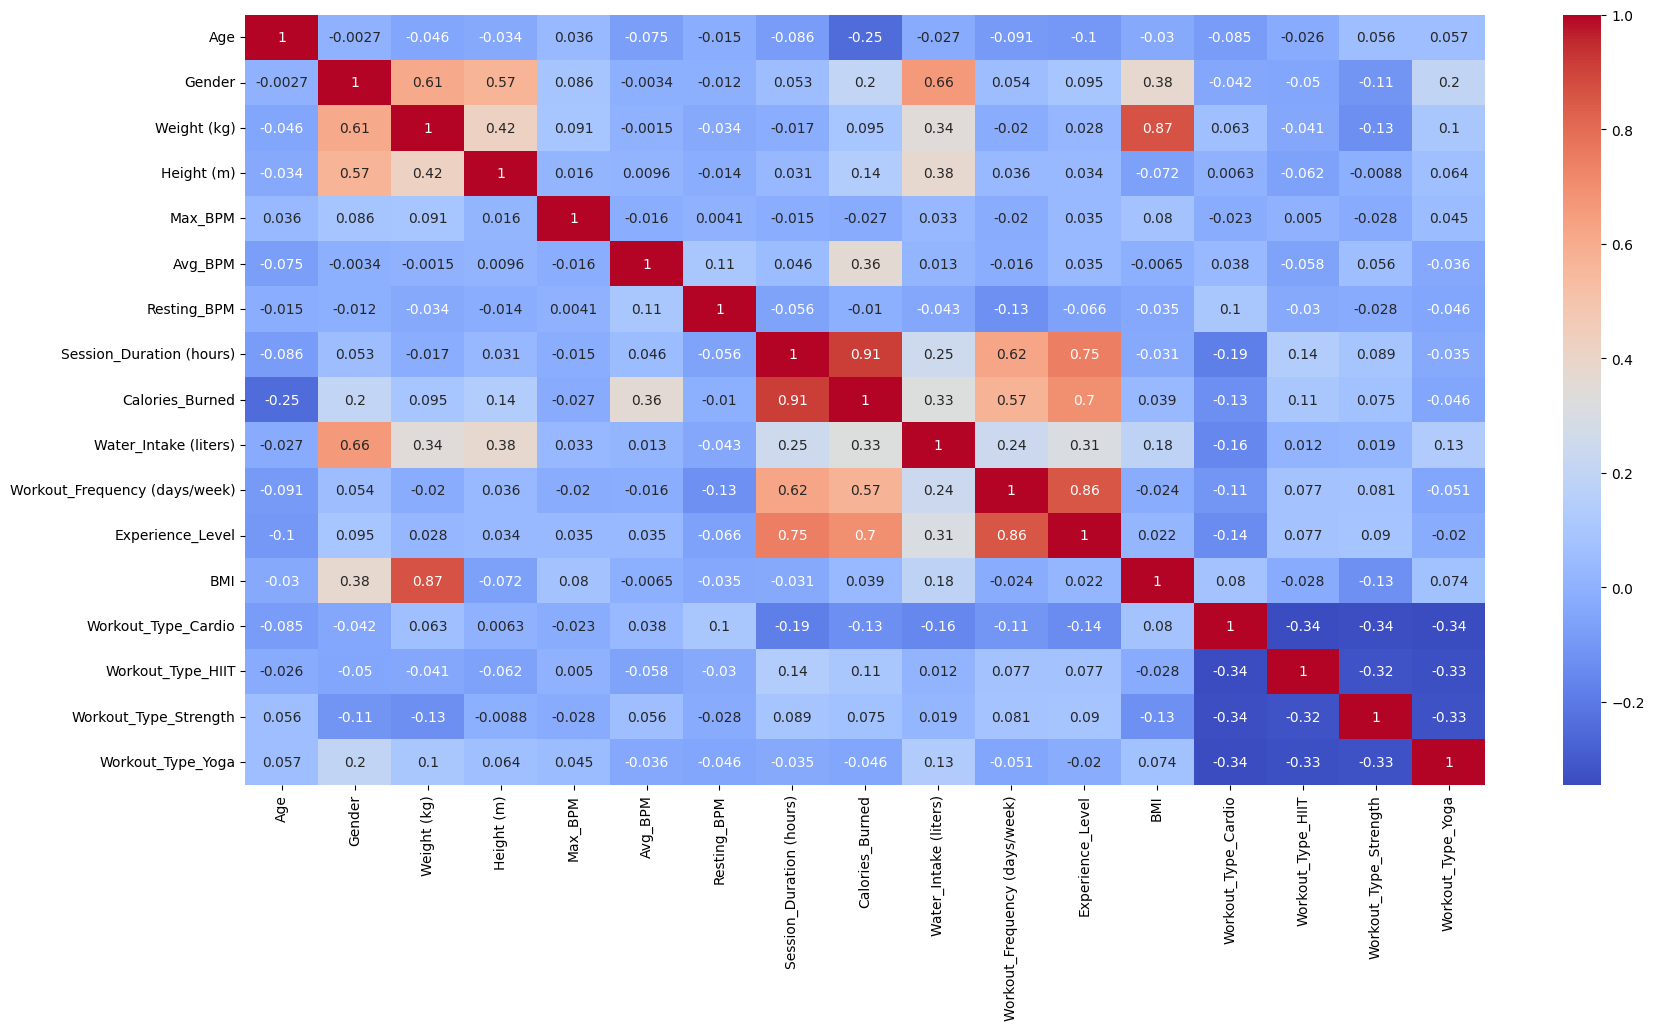

In [20]:
plt.figure(figsize=(20, 10))
sns.heatmap(X_test_transformed_scaled.corr(), annot=True, cmap='coolwarm')

Based on the analysis of this correlation matrix, We will drop the following features


*  Calories_Burned
*   Workout_Frequency (days/week)
* Weight (kg)
using a correlation threshold of 0.85.



In [21]:

features_to_drop = ['Calories_Burned', 'Workout_Frequency (days/week)', 'Weight (kg)']

X_train_final = X_train_transformed_scaled.drop(columns=features_to_drop, axis=1)
X_test_final = X_test_transformed_scaled.drop(columns=features_to_drop, axis=1)

print("Training dataset shape after dropping features:", X_train_final.shape)
print("Testing dataset shape after dropping features:", X_test_final.shape)

Training dataset shape after dropping features: (776, 14)
Testing dataset shape after dropping features: (195, 14)


In [22]:
X_train_final.head()

,Age,Gender,Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Water_Intake (liters),Experience_Level,BMI,Workout_Type_Cardio,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga
865,0.073171,1.0,0.68,0.538462,0.244898,0.000000,0.533333,0.818182,0.0,0.506924,0.0,0.0,0.0,1.0
192,0.024390,0.0,0.04,0.717949,0.204082,0.875000,0.486667,0.409091,0.0,0.458742,1.0,0.0,0.0,0.0
309,0.121951,0.0,0.56,0.641026,0.428571,0.333333,0.780000,0.545455,1.0,0.181766,0.0,0.0,0.0,1.0
477,0.804878,0.0,0.16,0.102564,0.183673,0.625000,0.240000,0.363636,0.0,0.409694,0.0,1.0,0.0,0.0
896,0.097561,0.0,0.04,0.230769,0.938776,0.458333,0.886667,0.545455,1.0,0.416330,0.0,0.0,0.0,1.0


In [23]:
X_test_final.head()

,Age,Gender,Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Water_Intake (liters),Experience_Level,BMI,Workout_Type_Cardio,Workout_Type_HIIT,Workout_Type_Strength,Workout_Type_Yoga
168,0.878049,0.0,0.56,0.076923,0.591837,0.916667,0.513333,0.136364,0.0,0.302943,1.0,0.0,0.0,0.0
836,0.121951,0.0,0.24,0.820513,0.734694,0.375000,0.580000,0.454545,0.5,0.361223,1.0,0.0,0.0,0.0
76,0.585366,0.0,0.44,0.589744,0.448980,1.000000,0.580000,0.045455,0.0,0.168205,1.0,0.0,0.0,0.0
70,0.951220,0.0,0.04,0.256410,0.183673,0.083333,0.820000,0.545455,1.0,0.443739,0.0,0.0,1.0,0.0
88,0.243902,1.0,0.32,0.358974,0.673469,0.000000,0.393333,0.909091,0.5,0.498846,0.0,0.0,0.0,1.0


## MODELS

We define a class to compute and display R², MAE, and RMSE metrics for model predictions in a readable format.

In [24]:


class ResultMetrics:
    def __init__(self, model_name, y_true, y_pred):
        self.model_name = model_name
        self.r2 = r2_score(y_true, y_pred)
        self.mae = mean_absolute_error(y_true, y_pred)
        self.mse = np.sqrt(mean_squared_error(y_true, y_pred))

    def __str__(self):
        return f"{self.model_name} -> R2: {self.r2:.4f}, MAE: {self.mae:.2f}, RMSE: {self.rmse:.2f}"


In [25]:

models = {
    'KNN': KNeighborsRegressor(),
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42)
}

test_results = {}
train_results = {}
best_score = 0
best_model = None

for name, model in models.items():
    model.fit(X_train_final, y_train)

    y_train_pred = model.predict(X_train_final)
    y_test_pred = model.predict(X_test_final)

    train_result = ResultMetrics(name, y_train, y_train_pred)
    test_result = ResultMetrics(name, y_test, y_test_pred)

    train_results[name] = train_result
    test_results[name] = test_result

    if test_result.r2 > best_score:
        best_score = test_result.r2
        best_model = (name, model)

    print(f"{name} R2 Score on Test Data: {test_result.r2:.4f}")

KNN R2 Score on Test Data: 0.7340
LinearRegression R2 Score on Test Data: 0.6113
RandomForest R2 Score on Test Data: 0.7743
XGBoost R2 Score on Test Data: 0.7295


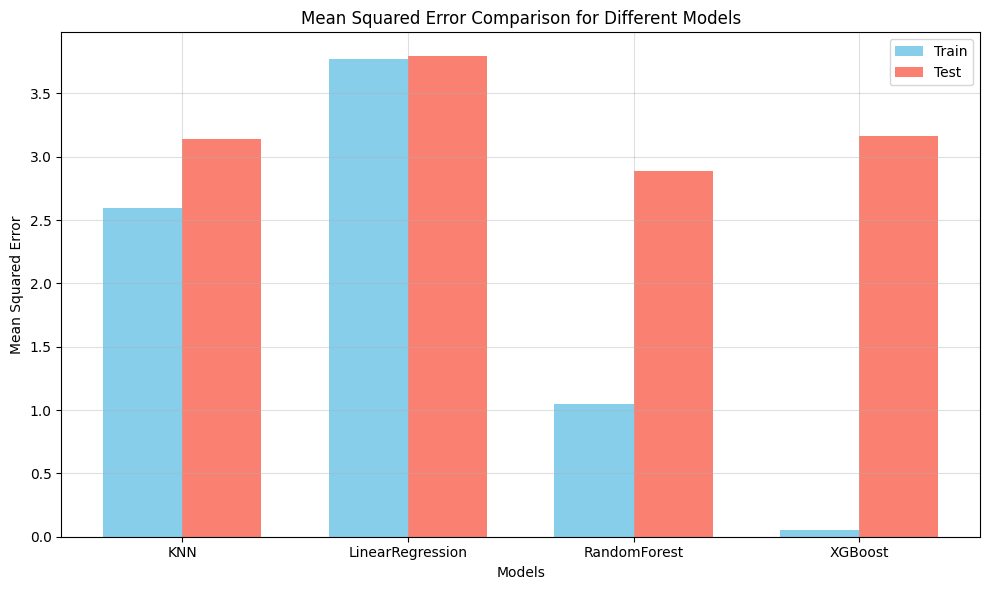

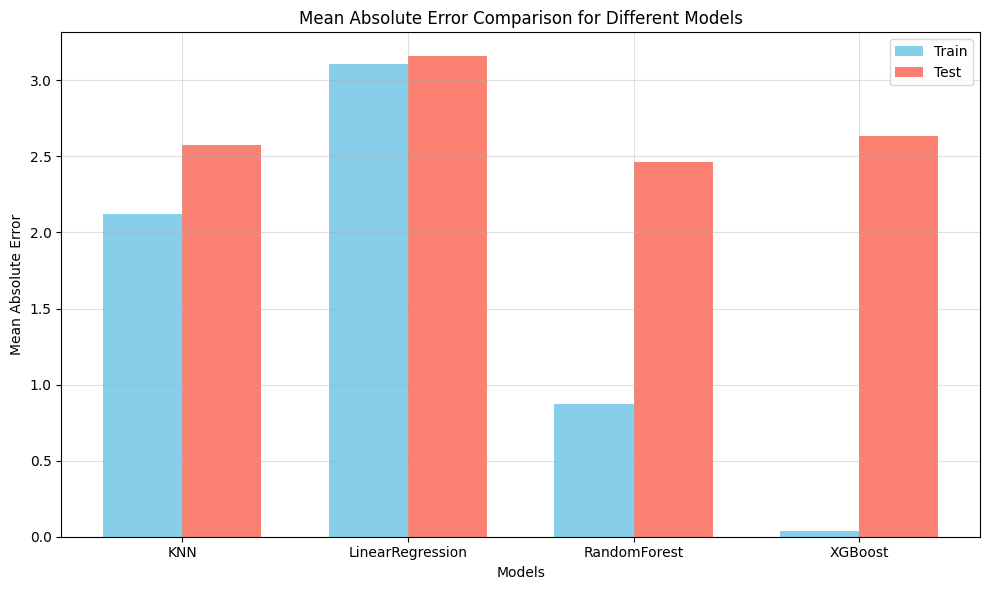

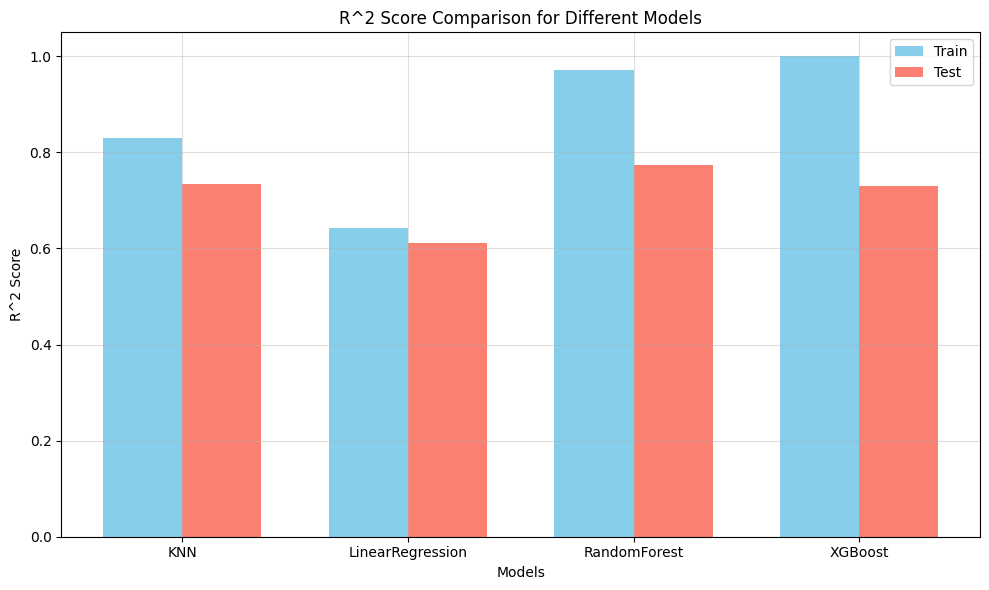

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def plot_comparison_metrics(train_results, test_results):
    metrics = ['mse', 'mae', 'r2']
    metric_names = ['Mean Squared Error', 'Mean Absolute Error', 'R^2 Score']

    for metric, metric_name in zip(metrics, metric_names):
        plt.figure(figsize=(10, 6))

        # Extract metric values from results
        train_metric_values = [getattr(train_results[model], metric) for model in train_results]
        test_metric_values = [getattr(test_results[model], metric) for model in test_results]

        x = np.arange(len(train_results))
        width = 0.35

        # Plotting bars
        plt.bar(x - width/2, train_metric_values, width, label='Train', color='skyblue')
        plt.bar(x + width/2, test_metric_values, width, label='Test', color='salmon')

        # Plot settings
        plt.xlabel('Models')
        plt.ylabel(metric_name)
        plt.title(f'{metric_name} Comparison for Different Models')
        plt.xticks(x, train_results.keys())
        plt.legend()
        plt.grid(alpha=0.4)
        plt.tight_layout()
        plt.show()

# Usage
plot_comparison_metrics(train_results, test_results)


On analyzing the test and training r2_score of our Random forest, we realize that it is overfitting and not generalizing as well on the test dataset. Therefore, we will prefer the second best, which is KNN Regressor

In [27]:
import joblib

best_model = ('KNN', models['KNN'])

print('\n')
print(f" Best Model: {best_model[0]}")
print(f"\n Training Set Performance:")
print(f"- Mean Squared Error: {train_results[best_model[0]].mse:.3f}")
print(f"- Mean Absolute Error: {train_results[best_model[0]].mae:.3f}")
print(f"- R^2 Score: {train_results[best_model[0]].r2:.4f}")

print(f"\n Testing Set Performance:")
print(f"- Mean Squared Error: {test_results[best_model[0]].mse:.3f}")
print(f"- Mean Absolute Error: {test_results[best_model[0]].mae:.3f}")
print(f"- R^2 Score: {test_results[best_model[0]].r2:.4f}")

# Save the best model to a file
joblib.dump(best_model[1], 'model/best_model.pkl')
print(" Best model saved to 'model/best_model.pkl'")




 Best Model: KNN

 Training Set Performance:
- Mean Squared Error: 2.596
- Mean Absolute Error: 2.122
- R^2 Score: 0.8305

 Testing Set Performance:
- Mean Squared Error: 3.137
- Mean Absolute Error: 2.574
- R^2 Score: 0.7340
 Best model saved to 'model/best_model.pkl'


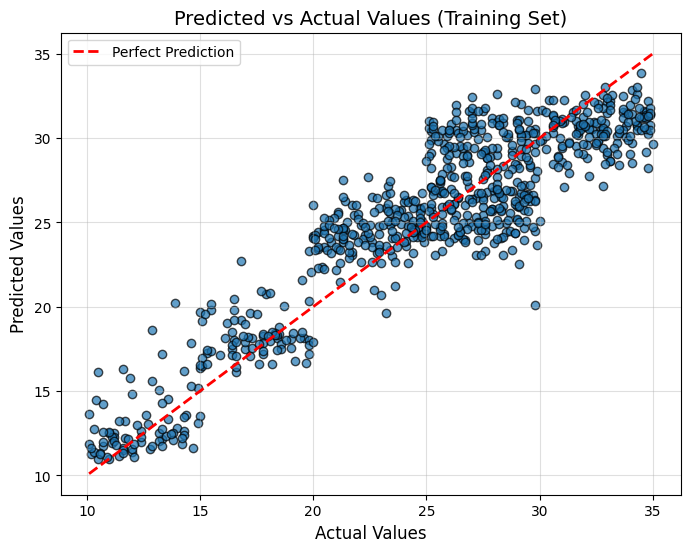

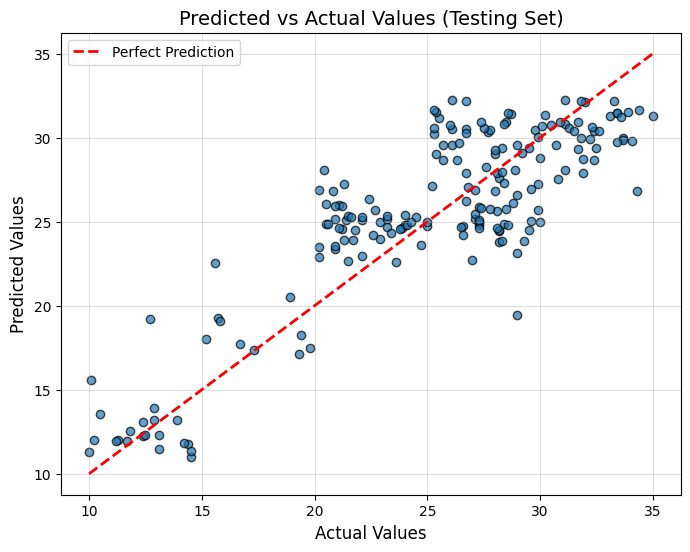

In [28]:
def plot_results(y_true, y_pred, dataset_type):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.7, edgecolor='k')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2, label='Perfect Prediction')
    plt.title(f"Predicted vs Actual Values ({dataset_type} Set)", fontsize=14)
    plt.xlabel("Actual Values", fontsize=12)
    plt.ylabel("Predicted Values", fontsize=12)
    plt.legend()
    plt.grid(alpha=0.4)
    plt.show()

y_train_pred = best_model[1].predict(X_train_final)
y_test_pred = best_model[1].predict(X_test_final)
# Plot for training set
plot_results(y_train, y_train_pred, "Training")

# Plot for testing set
plot_results(y_test, y_test_pred, "Testing")

In [46]:
def test(X_test):
    X_test = X_test.copy()
    model = joblib.load('model/best_model.pkl')
    encoder = joblib.load('model/workout_type_encoder.pkl')
    scaler = joblib.load('model/minmax_scaler.pkl')

    X_test['Gender'] = X_test['Gender'].map({'Female': 0, 'Male': 1})
    test_encodings = encoder.transform(X_test[['Workout_Type']])
    test_encodings_df = pd.DataFrame(
        test_encodings,
        columns=encoder.get_feature_names_out(['Workout_Type']),
        index=X_test.index
    )
    X_test = pd.concat([X_test.drop('Workout_Type', axis=1), test_encodings_df], axis=1)

    X_test_scaled = scaler.transform(X_test)
    X_test = pd.DataFrame(
        X_test_scaled,
        columns=X_test.columns,   # Preserve column names
        index=X_test.index        # Preserve index
    )
    features_to_drop = ['Calories_Burned', 'Workout_Frequency (days/week)', 'Weight (kg)']
    X_test = X_test.drop(columns=features_to_drop, axis=1)

    y_pred = model.predict(X_test)
    return y_pred

In [47]:
X_test

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI
168,54,Female,72.3,1.78,163,149,72,1.27,852.0,Cardio,1.8,2,1,22.82
836,23,Female,65.2,1.62,192,156,59,1.37,1069.0,Cardio,2.5,3,2,24.84
76,42,Female,53.7,1.72,183,142,74,1.37,875.0,Cardio,1.6,3,1,18.15
70,57,Female,64.0,1.52,170,129,52,1.73,1004.0,Strength,2.7,5,3,27.70
88,28,Male,81.6,1.66,174,153,50,1.09,917.0,Yoga,3.5,4,2,29.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,20,Male,55.0,1.60,172,168,67,1.12,1035.0,Yoga,3.2,4,2,21.48
633,53,Male,68.5,1.97,194,139,69,1.30,894.0,HIIT,2.1,3,2,17.65
557,22,Male,86.2,1.90,186,128,58,1.91,1345.0,Strength,3.5,5,3,23.88
33,24,Female,58.9,1.51,187,157,68,1.04,816.0,Cardio,2.5,2,1,25.83


In [48]:
X_test.columns

Index(['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM',
       'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned',
       'Workout_Type', 'Water_Intake (liters)',
       'Workout_Frequency (days/week)', 'Experience_Level', 'BMI'],
      dtype='object')

In [49]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195 entries, 168 to 31
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            195 non-null    int64  
 1   Gender                         195 non-null    object 
 2   Weight (kg)                    195 non-null    float64
 3   Height (m)                     195 non-null    float64
 4   Max_BPM                        195 non-null    int64  
 5   Avg_BPM                        195 non-null    int64  
 6   Resting_BPM                    195 non-null    int64  
 7   Session_Duration (hours)       195 non-null    float64
 8   Calories_Burned                195 non-null    float64
 9   Workout_Type                   195 non-null    object 
 10  Water_Intake (liters)          195 non-null    float64
 11  Workout_Frequency (days/week)  195 non-null    int64  
 12  Experience_Level               195 non-null    int64  

In [50]:
def test(age: int, gender: str, weight: float, height: float, max_bpm: int, avg_bpm: int, resting_bpm: int, session_duration: float, calories_burned: float, workout_type: str, water_intake: float, workout_frequency: int, experience_level: int,bmi :float) -> float:
    columns = ['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM',
       'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned',
       'Workout_Type', 'Water_Intake (liters)',
       'Workout_Frequency (days/week)', 'Experience_Level', 'BMI']
    data = [age,gender,weight,height,max_bpm,avg_bpm,resting_bpm,session_duration,calories_burned,workout_type,water_intake,workout_frequency,experience_level,bmi]
    X_test = pd.DataFrame([data], columns=columns)
    model = joblib.load('model/best_model.pkl')
    encoder = joblib.load('model/workout_type_encoder.pkl')
    scaler = joblib.load('model/minmax_scaler.pkl')

    X_test['Gender'] = X_test['Gender'].map({'Female': 0, 'Male': 1})
    test_encodings = encoder.transform(X_test[['Workout_Type']])
    test_encodings_df = pd.DataFrame(
        test_encodings,
        columns=encoder.get_feature_names_out(['Workout_Type']),
        index=X_test.index
    )
    X_test = pd.concat([X_test.drop('Workout_Type', axis=1), test_encodings_df], axis=1)

    X_test_scaled = scaler.transform(X_test)
    X_test = pd.DataFrame(
        X_test_scaled,
        columns=X_test.columns,   # Preserve column names
        index=X_test.index        # Preserve index
    )
    features_to_drop = ['Calories_Burned', 'Workout_Frequency (days/week)', 'Weight (kg)']
    X_test = X_test.drop(columns=features_to_drop, axis=1)

    y_pred = model.predict(X_test)
    return y_pred[0]

In [51]:
X_test.iloc[0]

,168
Age,54
Gender,Female
Weight (kg),72.3
Height (m),1.78
Max_BPM,163
Avg_BPM,149
Resting_BPM,72
Session_Duration (hours),1.27
Calories_Burned,852.0
Workout_Type,Cardio


In [52]:

test(54,'Female',72.3,1.78,163,149,72,1.27,852.0,'Cardio',1.8,2, 1, 22.82)


np.float64(30.32)